In [164]:
import io
import torch

from pathlib import Path
import os
home = str(Path.home())

from PIL import Image
import requests
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.datasets import ImageNet

from ud188 import helper

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
fig_size = plt.rcParams["figure.figsize"]

In [60]:
fig_size[0] = 12
fig_size[1] = 4

In [61]:
fig_size

[12, 4]

## data preparation

To prepare data for transfer learning we use `pytorch` tools:

- `transforms`: to augment, resize and normalize data;
- `datasets.ImageFolder`: to load data from disk;
- `torch.utils.data.DataLoader`: to create data loaders;

### `data_dir` structure

We have `133` dog breeds, data is already splitted on `train` etc. Structure of folders inside `dogImages`:

- `train`
    - `001.Affenpinscher`
    - `002.Afghan_hound`
    - `003.Airedale_terrier`
    - `...`
- `valid`
    - `...`

In [11]:
data_dir = Path.home() / 'data/dog_breed/dogImages'

In [12]:
data_dir

PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages')

In [17]:
[d for d in data_dir.glob('*') if d.is_dir()]

[PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/valid'),
 PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/test'),
 PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train')]

In [24]:
len([d for d in data_dir.glob('train/*') if d.is_dir()])

133

In [30]:
len([d for d in data_dir.glob('valid/*') if d.is_dir()])

133

In [25]:
sorted([d for d in data_dir.glob('train/*') if d.is_dir()])[:5]

[PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/001.Affenpinscher'),
 PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/002.Afghan_hound'),
 PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/003.Airedale_terrier'),
 PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/004.Akita'),
 PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/005.Alaskan_malamute')]

In [28]:
len(list(data_dir.glob('train/001.Affenpinscher/*')))

64

How many images of each breed in training data do we have?

In [43]:
n_images = [len(list(data_dir.glob(f'train/{i:0>3}.*/*'))) for i in range(1, 134)]

In [44]:
n_images[:5]

[64, 58, 52, 63, 77]

In [109]:
sum(n_images)

6680

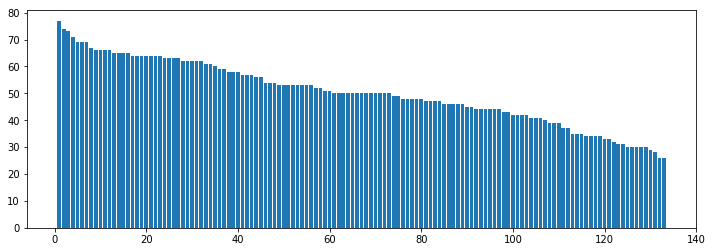

In [72]:
plt.bar(range(1, 134), sorted(n_images, reverse=True));

Let's now plot some images.

In [67]:
affenpinschers = sorted(list(data_dir.glob(f'train/001.*/*')))

In [69]:
len(affenpinschers), affenpinschers[:3]

(64,
 [PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'),
  PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg'),
  PosixPath('/Users/ilyarudyak/data/dog_breed/dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg')])

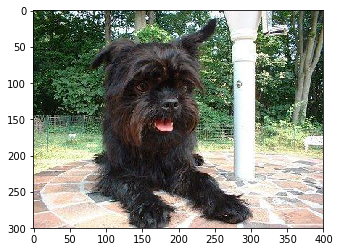

In [70]:
filename = affenpinschers[0]
img = Image.open(filename)
imshow(img);

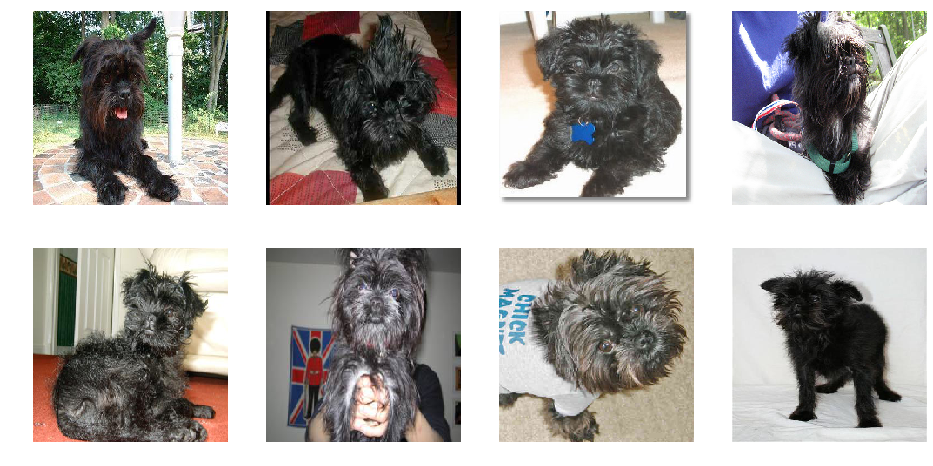

In [145]:
nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,8));
counter = 0
for i in range(nrows):
    for j in range(ncols):
        img = Image.open(affenpinschers[counter])
        counter += 1
        img = img.resize((224, 224))
        ax[i, j].axis('off')
        ax[i, j].imshow(img)

### transforms

We may see that indeed our images are augmented. To show images we can't use `imshow()` anymore. We use `helper.imshow()` from `ud188` course. We may also see that some transforms are not that meaningful so we probably should be careful when using them.

In [149]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

In [150]:
train_dataset = datasets.ImageFolder(data_dir / 'train', 
                                     transform=train_transforms)

In [151]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=8, 
                                           shuffle=False)

In [152]:
images, labels = next(iter(train_loader))

In [153]:
images.shape

torch.Size([8, 3, 224, 224])

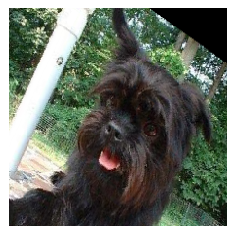

In [157]:
helper.imshow(images[0], normalize=False);

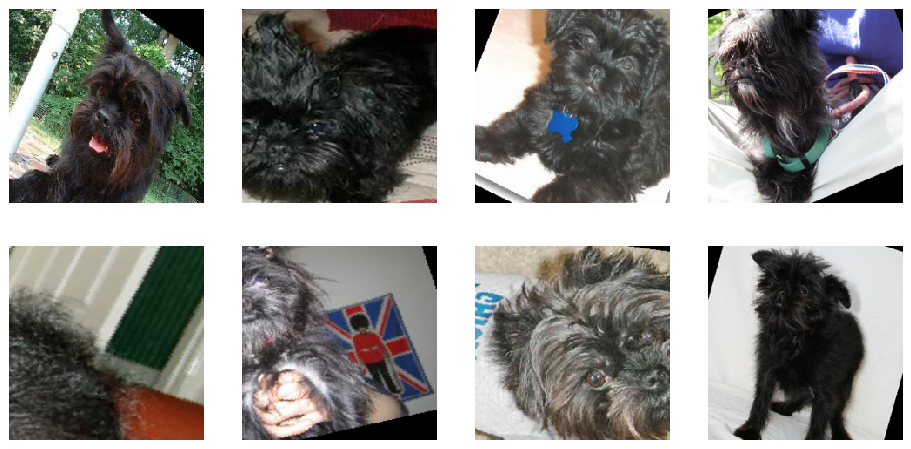

In [158]:
nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,8));
counter = 0
for i in range(nrows):
    for j in range(ncols):
        img = images[counter]
        counter += 1
        helper.imshow(image=img, ax=ax[i, j], normalize=False)

## transfer learning

Let's first do transfer learning with `VGG16` and training routines provided in the assignment. Basically the only thing we're doing - we're changing `classifier` of `VGG16` model.

Then we will use more sophisticated models and routines that can be compared to `fastai` library. We'll also try to unfreeze more layers.

In [159]:
model = models.vgg16(pretrained=True)

In [175]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [165]:
n_classes = 133
classifier = nn.Sequential(nn.Linear(25088, 4096),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(512, n_classes))

In [166]:
model.classifier = classifier

In [167]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1